In [24]:
from ultralytics import YOLO
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageFilter, ImageOps

from utils import find_bounding_box
from scipy.ndimage import binary_dilation

### import tqdm for progress bar
from tqdm import tqdm

### disable warnings
import warnings
warnings.filterwarnings("ignore")

from skimage import measure

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.transforms import Bbox

In [26]:
img_open = Image.open(r"C:\Users\larth\Desktop\Scannerizzazioni_tavolette_SALT\Scansioni\1.tif")

In [27]:
from PIL import Image, ImageDraw, ImageFont

In [28]:
from skimage.morphology import remove_small_objects

In [32]:
def apply_model(model_dir, 
                imgs_dir, 
                tabular_file, 
                PIXEL_CM_RATIO = 118.11, 
                mode_filter = 50, 
                diagnostic = False, 
                diagnostic_plots = False,
                add_bar = False):
    


    ROOT_DIR = Path(".")

    model_path = ROOT_DIR / model_dir
    imgs_path = ROOT_DIR / imgs_dir
    tabular_file = ROOT_DIR / tabular_file

    os.makedirs(ROOT_DIR / "prediction_diagnostic", exist_ok=True)
    os.makedirs(ROOT_DIR / "processed_imgs", exist_ok=True)

    # Load model
    model = YOLO(model_path/ "best.pt" , task='segment')

    tabular_file = pd.read_excel(tabular_file)

    processed_imgs = []    

    ## start the loop

    for img in tqdm(os.listdir(imgs_path)[:5]) if diagnostic else tqdm(os.listdir(imgs_path)):
        
        order = []
        img_list = []
        mask_list = []     
        
        img_name = img.split(".")[0]

        img_open = Image.open(imgs_path/img)

        results = model.predict(img_open, save_crop=False, conf = 0.4, retina_masks = True, verbose = False)

        result_array = results[0].plot(masks=True)

        ### Create a series of diagnostic plots if specified

        if diagnostic_plots:
        
            fig = plt.figure(figsize=(8, 8))
           
            plt.imshow(result_array)

            fig.savefig(ROOT_DIR / "prediction_diagnostic" / f"{img_name}_prediction.png", dpi=300, bbox_inches="tight")

            plt.close(fig)

        ### Extract the masks

        extracted_masks = results[0].masks.data
        masks_array = extracted_masks.cpu().numpy()

        ### Sort the masks by the x coordinate of the bounding box       

        for i in range(len(masks_array)):
            num = find_bounding_box(masks_array[i])[2]
            order.append((i, num))         

        ### sort the masks by the x coordinate of the bounding box
        order.sort(key=lambda x: x[1]) 

        ### Select corresponding tabular data
        df_info_tab = tabular_file.loc[tabular_file["TAV"] == int(img_name)]        
        df_info_tab["RIB"] = df_info_tab["RIB"].astype(bool) 

        if len(order) == len(df_info_tab):

            for i in range(len(order)):
                img_list.append(Image.fromarray(masks_array[order[i][0]].astype(np.uint8) * 255))


            img_list_processed = [img.filter(ImageFilter.ModeFilter(size=mode_filter)) for img in img_list]
            img_array_processed = np.array(img_list_processed)        

            for i in range(len(img_array_processed)):
                rmin, rmax, cmin, cmax = find_bounding_box(img_array_processed[i])
                mask = img_array_processed[i][rmin:rmax, cmin:cmax]
                mask = mask / 255
                mask = remove_small_objects(mask.astype(bool), min_size=mask.sum()//10, connectivity=1).astype(int)


                if df_info_tab.iloc[i]["RIB"] == True:
                    mask = np.flip(mask, axis=1)

                mask_list.append(mask)
                processed_imgs.append((img_name, df_info_tab.iloc[i]['INV (PT)'].astype(int), mask))

            for ids, mask in enumerate(mask_list):

                ### for each row, get the first and pixel of the mask
                first_pixel = []
                for i in range(mask.shape[0]):
                    for j in range(mask.shape[1]):
                        if mask[i, j] == 1:
                            first_pixel.append((i, j))
                            break

                contours = measure.find_contours(np.pad(mask, (1,1)))

                contour_image = np.zeros_like(np.pad(mask, (1,1)))

                my_list = []

                for contour in contours:
                    for coord in contour:
                        x, y = int(coord[0]), int(coord[1])
                        contour_image[x, y] = 1
                        my_list.append((x,y))

                contour_image_2 = np.zeros_like(contour_image)

                first_possibile_value = [first_pixel[0][1] + 1, first_pixel[0][1], first_pixel[0][1]-1]
                second_possibile_value = [first_pixel[0][0] + 1, first_pixel[0][0], first_pixel[0][0]-1]

                values = []
                for possible_value in first_possibile_value:
                    for second_possible_value in second_possibile_value:
                        if contour_image[second_possible_value, possible_value] == 1:
                            values.append((second_possible_value, possible_value))

                index_point = my_list.index(values[0])

                for x, y in my_list[:index_point]:
                            contour_image_2[x, y] = 1

                ### for each row, get the first and pixel of the mask
                first_pixel = []
                for i in range(mask.shape[0]):
                    for j in range(mask.shape[1]):
                        if mask[i, j] == 1:
                            first_pixel.append((i, j))
                            break

                ### remove the fraction of the first pixel using the gradient
                gradients = np.gradient(np.array(first_pixel)[:, 1], axis=0)
                zero_gradient_mask = gradients == 0
                last_zero_gradient = np.where(zero_gradient_mask)[0][-1]
                                
                # get the diameter of the pot in pixel
                diam_pix = df_info_tab.iloc[ids]["DIAM (cm)"] * PIXEL_CM_RATIO

                if diam_pix > 0:
                    ### create a mask with the first pixel of each row
                    first_pixel_mask = np.zeros_like(mask)
                    for i, j in first_pixel:
                        if i < last_zero_gradient:
                            first_pixel_mask[i, j] = 1
                        elif i > last_zero_gradient and i > len(first_pixel)//2:
                            first_pixel_mask[i, j] = 0
                             
                    max_values = np.max(np.where(first_pixel_mask), axis=1)
                    contour_image_2[max_values[0]:, :] = 0
       
                    ### dilate the mask
                    first_pixel_mask = binary_dilation(contour_image_2, iterations=5)

                    ### remove 1 pixel from each side of the mask
                    first_pixel_mask = first_pixel_mask[1:-1, 1:-1]

                    ### real dimension of the pot in pixel
                    empty_mask = np.zeros((mask.shape[0], int(diam_pix + (my_list[index_point][1]*2))))

                    ### apply the mask and the first pixel mask to the empty mask
                    empty_mask[:, :mask.shape[1]] = mask
                    empty_mask_flipped = np.flip(empty_mask, axis=1)
                    empty_mask_flipped[:, :mask.shape[1]] = first_pixel_mask
                    empty_mask = np.flip(empty_mask_flipped, axis=1)

                    ### create the diameter rim mask
                    empty_mask[0:5, :] = 1

                    ### remove the diameter rim mask outside the profile and the first pixel mask
                    empty_mask = np.flip(empty_mask, axis=1)

                    for i, j in first_pixel:
                        empty_mask[i, :j] = 0

                    empty_mask = np.flip(empty_mask, axis=1)

                    for i, j in first_pixel:
                        empty_mask[i, :j] = 0

                    ### create the symmetry mask
                    empty_mask[:, empty_mask.shape[1] // 2: empty_mask.shape[1] // 2+5] = 1

                    

                    res = empty_mask.copy()

                    res_2 = Image.fromarray(res * 255)

                    res_2= res_2.convert("L")

                    res_2 = ImageOps.invert(res_2)      

                    res_2 = ImageOps.expand(res_2, border=200, fill='white')

                    ### add a bar
                    if add_bar:
                        np_pipe = np.array(res_2)
                    
                        initial_x = int(np_pipe.shape[1]*0.05)
                        final_x = int(np_pipe.shape[1]*0.05 + PIXEL_CM_RATIO)

                        initial_y = int(np_pipe.shape[0]*0.95)
                        final_y = int(np_pipe.shape[0]*0.95 + 10)

                        np_pipe[initial_y:final_y, initial_x:final_x] = 1

                        res_2 = Image.fromarray(np_pipe)


                    ### add a title to the image with the INV number a the bottom of the image
                    draw = ImageDraw.Draw(res_2)


                    font = ImageFont.truetype("arial.ttf", 100)
                    draw.text((25, 10), f"{df_info_tab.iloc[ids]['INV (PT)'].astype(int)}", 
                              (0), font=font,
                              align="center")


                    res_2.save(f"processed_imgs/{df_info_tab.iloc[ids]['INV (PT)'].astype(int)}.jpg")
                    


                   

                else:

                    res_2 = Image.fromarray(mask * 255)
                    res_2= res_2.convert("L")
                    res_2 = ImageOps.invert(res_2)      
                    res_2 = ImageOps.expand(res_2, border=200, fill='white')
                    ### add a bar
                    if add_bar:
                        np_pipe = np.array(res_2)
                    
                        initial_x = int(np_pipe.shape[1]*0.05)
                        final_x = int(np_pipe.shape[1]*0.05 + PIXEL_CM_RATIO)

                        initial_y = int(np_pipe.shape[0]*0.95)
                        final_y = int(np_pipe.shape[0]*0.95 + 10)

                        np_pipe[initial_y:final_y, initial_x:final_x] = 1

                        res_2 = Image.fromarray(np_pipe)
                        
                    draw = ImageDraw.Draw(res_2)
                    font = ImageFont.truetype("arial.ttf", 100)
                    draw.text((25, 10), f"{df_info_tab.iloc[ids]['INV (PT)'].astype(int)}", 
                              (0), font=font,
                              align="center")                                               
                    res_2.save(f"processed_imgs/{df_info_tab.iloc[ids]['INV (PT)'].astype(int)}.jpg")
            
        else:
            print(f"Error in image {img_name}: number of masks does not match the number of rows in the tabular file. The image will be skipped.")
                
    return processed_imgs

In [33]:
processed_images = apply_model(model_dir=r"model",
            imgs_dir=r"real_scansioni",
            tabular_file = r"Tavolette_Sigle_unico.xlsx", 
            mode_filter=20,
            diagnostic=True,
            diagnostic_plots=True,
            add_bar=True)

100%|██████████| 5/5 [00:53<00:00, 10.70s/it]


In [14]:
tabs = [x[0] for x in processed_images]
invs = [x[1] for x in processed_images]
masks = [x[2] for x in processed_images]


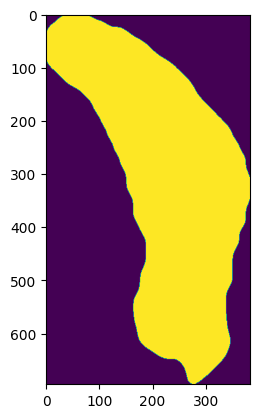

In [15]:
plt.imshow(masks[0])

In [16]:
img_dims = [mask.shape for mask in masks]

In [17]:
max_imgs = np.max(img_dims, axis=0)

In [18]:
max_imgs, len(masks)

(array([1371,  637]), 312)

In [19]:
### create an empty array with the maximum dimensions of the images

empty_array = np.zeros((len(masks), max_imgs[0], max_imgs[1]))

In [20]:
empty_array.shape

(312, 1371, 637)

In [21]:
for i, mask in enumerate(masks):
    empty_array[i, :mask.shape[0], :mask.shape[1]] = mask

In [22]:
### resize the images to 256x256 using skimage

from skimage.transform import resize

resized_array = np.array([resize(mask, (256, 256)) for mask in empty_array])

In [23]:
### transform the array into a sparse matrix
from scipy.sparse import csr_matrix

#sparse_matrix = csr_matrix(resized_array.reshape(len(masks), -1))

sparse_matrix_2 = csr_matrix(empty_array.reshape(len(masks), -1))


### save the sparse matrix

from scipy.sparse import save_npz

#save_npz("sparse_matrix.npz", sparse_matrix)
save_npz("sparse_matrix_2.npz", sparse_matrix_2)

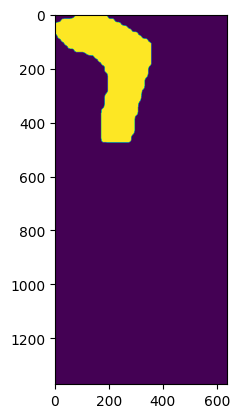

In [46]:
plt.imshow(empty_array[55])

In [46]:
cnts = []

for mask in masks:
    contour = measure.find_contours(np.pad(mask, (1,1)))
    cnts.append(contour)


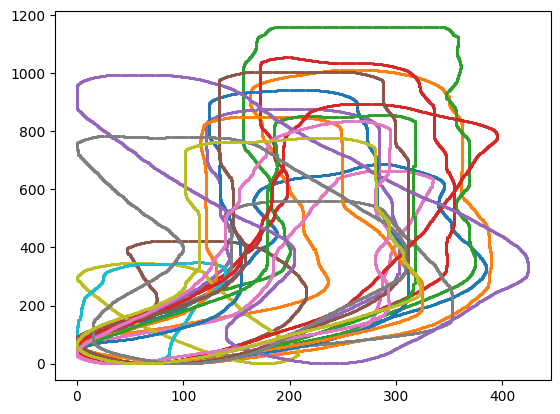

In [47]:
for cnt in cnts:
    for c in cnt:
        plt.scatter(c[:, 1], c[:, 0], linewidth=1, s=1)